<a href="https://colab.research.google.com/github/AndreRab/Covid-bot-using-LSTM/blob/main/Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data downloading

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.read_csv('covid_faq.csv')
df2 = pd.read_csv('COVID19_FAQ.csv')
df3 = pd.read_csv('news_CSV.csv', encoding='ISO-8859-1')

In [ ]:
df1.head()

,questions,answers
0,What is a novel coronavirus?,A novel coronavirus is a new coronavirus that ...
1,Why is the disease being called coronavirus di...,"On February 11, 2020 the World Health Organiza..."
2,How does the virus spread?,The virus that causes COVID-19 is thought to s...
3,Can I get COVID-19 from food (including restau...,Currently there is no evidence that people can...
4,Will warm weather stop the outbreak of COVID-19?,It is not yet known whether weather and temper...


In [ ]:
df2.head()

,questions,answers
0,1. How does COVID-19 spread?,People can catch COVID-19 from others who have...
1,2. What are the symptoms of COVID-19?,The most common symptoms of COVID-19 are fever...
2,3. How do I know if it is COVID-19 or just the...,A COVID-19 infection has the same signs and sy...
3,4. Can the virus that causes COVID-19 be trans...,Studies to date suggest that the virus that ca...
4,5. What can I do to protect myself and prevent...,Protection measures for everyone Stay aware ...


In [ ]:
df3.head()

,response,context
0,"Symptoms include fever, coughing, sore throat,...",What are the symptoms?
1,Your doctor will tell you if you need to get t...,When should I get tested?
2,"As cases of coronavirus surge, health authorit...",What's the difference between physical distanc...
3,If you have been in contact with a person with...,How do I practice physical distancing?
4,Physical distancing is the reason the Federal ...,What's closed?


In [ ]:
questions_3 = df3.context
df3.context = df3.response
df3.response = questions_3

In [ ]:
df3.head()

,response,context
0,What are the symptoms?,"Symptoms include fever, coughing, sore throat,..."
1,When should I get tested?,Your doctor will tell you if you need to get t...
2,What's the difference between physical distanc...,"As cases of coronavirus surge, health authorit..."
3,How do I practice physical distancing?,If you have been in contact with a person with...
4,What's closed?,Physical distancing is the reason the Federal ...


In [ ]:
print(df3.columns)

Index(['response', 'context'], dtype='object')


In [ ]:
df3.rename(columns = {'response': 'questions', 'context': 'answers'}, inplace=True)

In [ ]:
df3.head()

,questions,answers
0,What are the symptoms?,"Symptoms include fever, coughing, sore throat,..."
1,When should I get tested?,Your doctor will tell you if you need to get t...
2,What's the difference between physical distanc...,"As cases of coronavirus surge, health authorit..."
3,How do I practice physical distancing?,If you have been in contact with a person with...
4,What's closed?,Physical distancing is the reason the Federal ...


In [ ]:
df = pd.concat([df1, df2, df3])

In [ ]:
k = -900
print(df.questions.iloc[k])
print(df.answers.iloc[k])

where covid originate
early on, many of the patients at the epicenter of the covid outbreak in china had some link to a large seafood and live animal market, suggesting animal to person spread., wuhan city, china


In [ ]:
df = df.iloc[:-900, :]

In [ ]:
df

,questions,answers
0,What is a novel coronavirus?,A novel coronavirus is a new coronavirus that ...
1,Why is the disease being called coronavirus di...,"On February 11, 2020 the World Health Organiza..."
2,How does the virus spread?,The virus that causes COVID-19 is thought to s...
3,Can I get COVID-19 from food (including restau...,Currently there is no evidence that people can...
4,Will warm weather stop the outbreak of COVID-19?,It is not yet known whether weather and temper...
...,...,...
10276,where covid really come from,"early on, many of the patients at the epicente..."
10277,where covid come from,"early on, many of the patients at the epicente..."
10278,where covid started,"early on, many of the patients at the epicente..."
10279,what is the source of the virus,"early on, many of the patients at the epicente..."


## Data preprocessing

In [ ]:
from collections import Counter
import string

import nltk
from nltk.tokenize import word_tokenize

from tqdm import tqdm

import json

import torch
from torch.utils.data import Dataset, DataLoader

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
count_treshold = 1

signs = '\'()[].,?!:; '
numbers = ''.join([str(i) for i in range(10)])
extra_tokens = ['<bos>', '<eos>', '<unk>', '<pad>']

vocabular = set(list(signs.join(numbers)))
vocabular = vocabular.union(extra_tokens)

In [ ]:
words = Counter()
for answer in tqdm(df.answers.array):
    processed_text = str(answer).lower().translate(
    str.maketrans("", "", string.punctuation))

    for word in word_tokenize(processed_text):
        words[word] += 1

for word, count in words.items():
    if count > count_treshold:
        vocabular.add(word)

print(f"Length of the vocabular is {len(vocabular)}")

100%|██████████| 10465/10465 [00:06<00:00, 1700.53it/s]

Length of the vocabular is 16848


In [ ]:
ind2word = {index: word for index, word in enumerate(vocabular)}
word2ind = {word: index for index, word in ind2word.items()}

In [ ]:
with open('word2ind.json', 'w') as f:
    json.dump(word2ind, f)

with open('ind2word.json', 'w') as f:
    json.dump(ind2word, f)

In [ ]:
class FAQ_Dataset(Dataset):
    def __init__(self, questions, answers, is_train):
        assert len(questions) == len(answers), 'Sizes don\'t equal'
        self.questions = list(questions)
        self.is_train = is_train
        if is_train:
            self.answers = list(answers)
        self.bos = word2ind['<bos>']
        self.eos = word2ind['<eos>']
        self.pad = word2ind['<pad>']
        self.unk = word2ind['<unk>']

    def __getitem__(self, idx):
        tokenized_question = self.text2tokens(self.questions[idx])

        if self.is_train:
            tokenized_answer = self.text2tokens(self.answers[idx])
            return {
                'questions': tokenized_question,
                'answers' : tokenized_answer
            }

        return { 'question': tokenized_question }

    def text2tokens(self, text):
        processed_text = str(text).lower()

        tokenized_text = [self.bos]
        for word in word_tokenize(processed_text):
            tokenized_text += [word2ind.get(word, self.unk)]

        tokenized_text.append(self.eos)
        return tokenized_text

    def __len__(self):
        return len(self.questions)

In [ ]:
def make_same_size(batch_texts, max_len, pad_id):
    padded_texts = []
    for tokenized_text in batch_texts:
        tokenized_text = tokenized_text[:max_len]
        while len(tokenized_text) < max_len:
            tokenized_text.append(pad_id)
        padded_texts.append(tokenized_text)
    return padded_texts

def find_max_len(input_batch, max_len):
    lens = [len(text) for text in input_batch]
    return min(max(lens), max_len)

def collate_fn_with_padding(input_batch, pad_id=word2ind.get('<pad>', -1), max_len_question=256, max_len_answer=128):
    questions = [item['questions'] for item in input_batch]
    answers = [item['answers'] for item in input_batch] if 'answers' in input_batch[0] else None

    tokenized_questions_with_pad = make_same_size(
        questions,
        find_max_len(questions, max_len_question),
        pad_id
    )

    if 'answers' in input_batch[0].keys():
        tokenized_answers_with_pad = make_same_size(
            answers,
            find_max_len(answers, max_len_answer),
            pad_id
        )
        return {
            'questions': torch.tensor(tokenized_questions_with_pad, dtype=torch.long),
            'answers': torch.tensor(tokenized_answers_with_pad, dtype=torch.long)
        }

    return {
        'questions': torch.tensor(tokenized_questions_with_pad, dtype=torch.long)
    }

## Data splitting


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.questions
y = df.answers

batch_size = 32

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

train_dataset = FAQ_Dataset(X_train, y_train, True)
test_dataset = FAQ_Dataset(X_test, y_test, True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_with_padding)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_with_padding)

In [ ]:
train_loader.dataset.questions[100]

'Are the symptoms of COVID-19 different in children than in adults?'

## Model

In [ ]:
import torch.nn as nn
import random

import numpy as np

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, vocab_len, hidden_dim, input_size, max_answer_length, teaching_forcing=1.0):
        super(EncoderDecoder, self).__init__()
        self.vocab_len = vocab_len
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.teaching_forcing = teaching_forcing
        self.max_answer_length = max_answer_length

        self.encoder_embedding = nn.Embedding(vocab_len, input_size, padding_idx=word2ind['<pad>'])
        self.encoder_LSTM = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )

        self.decoder_embedding = nn.Embedding(vocab_len, hidden_dim, padding_idx=word2ind['<pad>'])
        self.decoder_LSTM = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )

        self.decoder_prediction = nn.Sequential(
            nn.Linear(hidden_dim, vocab_len)
        )

    def forward(self, x, target = None, device='cpu'):
        batch_size = x.shape[0]

        # Encoder
        embeddings = self.encoder_embedding(x)
        output, hidden = self.encoder_LSTM(embeddings)

        # Previous tokens for batch
        prev_token_idx = torch.tensor([word2ind['<bos>']] * batch_size).reshape(-1, 1).to(device)

        probs_tensor = None
        for i in range(self.max_answer_length):
            if i != 0 and target is not None and random.random() < self.teaching_forcing and target.shape[1] > i - 1:
                prev_token_idx = target[:, i - 1].reshape(-1, 1).to(device)
            embeddings = self.decoder_embedding(prev_token_idx)
            output, hidden = self.decoder_LSTM(embeddings, hidden)

            # Output is distribution for prediction
            output = self.decoder_prediction(output)
            # New previous token
            prev_token_idx = output.argmax(axis=2).reshape(-1, 1)  # axis=2 for batch-first

            if probs_tensor is None:
                probs_tensor = output.unsqueeze(0)
            else:
                probs_tensor = torch.cat((probs_tensor, output.unsqueeze(0)))

            if target is not None and i == target.shape[1] - 1:
                break

        # Transpose for dimension swapping
        return probs_tensor.transpose(1, 0)

In [ ]:
class EncoderDecoder2(nn.Module):
    def __init__(self, vocab_len, hidden_dim, input_size, max_answer_length, teaching_forcing=1.0):
        super(EncoderDecoder, self).__init__()
        self.vocab_len = vocab_len
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.teaching_forcing = teaching_forcing
        self.max_answer_length = max_answer_length

        self.embedding = nn.Embedding(vocab_len, hidden_dim, padding_idx=word2ind['<pad>'])
        self.encoder_LSTM = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )

        self.decoder_LSTM = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )

        self.decoder_prediction = nn.Sequential(
            nn.Linear(hidden_dim, vocab_len)
        )

    def forward(self, x, target=None, device='cpu'):
        batch_size = x.shape[0]

        embeddings = self.embedding(x)
        output, hidden = self.encoder_LSTM(embeddings)

        # Previous tokens for batch
        prev_token_idx = torch.tensor([word2ind['<bos>']] * batch_size).reshape(-1, 1).to(device)

        probs_tensor = None
        for i in range(self.max_answer_length):
            if i != 0 and target is not None and random.random() < self.teaching_forcing and target.shape[1] > i - 1:
                prev_token_idx = target[:, i - 1].reshape(-1, 1).to(device)

            embeddings = self.embedding(prev_token_idx)
            output, hidden = self.decoder_LSTM(embeddings, hidden)

            # Output is distribution for prediction
            output = self.decoder_prediction(output)
            # New previous token
            prev_token_idx = output.argmax(axis=2).reshape(-1, 1)

            if probs_tensor is None:
                probs_tensor = output.unsqueeze(0)
            else:
                probs_tensor = torch.cat((probs_tensor, output.unsqueeze(0)))

            if target is not None and i == target.shape[1] - 1:
                break

        return probs_tensor.transpose(1, 0)


## Train functions

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
def model_predict(string, model, is_string_converted = False, device='cpu'):
    model.to(device)
    if not is_string_converted:
      string_by_index = [word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(string)]
    else:
      string_by_index = string
    batch = torch.tensor([word2ind['<bos>']] + string_by_index + [word2ind['<eos>']], dtype=torch.long).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        probs_tensor = model(batch)

    indexes = probs_tensor.argmax(axis=-1).reshape(-1)

    output = [ind2word[index.item()] + " " for index in indexes]

    if '<eos>' + " " in output:
        output = output[:output.index('<eos>' + " ")]

    return ''.join(output)[:-1]


In [ ]:
def train(num_epochs, model, criterion, optimizer, train_loader, test_loader, vocab_len, device = 'cpu', clip_value = 1.0):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        model = model.to(device)
        model.train()

        loss_per_epoch = []
        for i, batch in tqdm(enumerate(train_loader), desc=f'Train epoch {epoch + 1}'):
            questions, answers = batch['questions'].to(device), batch['answers'].to(device)

            optimizer.zero_grad()
            output = model(questions, answers, device)

            loss = criterion(output.reshape(-1, vocab_len), answers[:, :output.size(1)].reshape(-1))

            loss_per_epoch.append(loss.item())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()

        train_loss.append(np.mean(loss_per_epoch))
        print(f"Train loss for {epoch + 1} is {train_loss[-1]}")

        model.eval()
        loss_per_epoch.clear()
        with torch.no_grad():
            for i, batch in tqdm(enumerate(test_loader), desc=f'Val epoch {epoch + 1}'):
                questions, answers = batch['questions'].to(device), batch['answers'].to(device)

                output = model(questions, answers, device)
                loss = criterion(output.reshape(-1, vocab_len), answers[:, :output.size(1)].reshape(-1))

                loss_per_epoch.append(loss.item())

        test_loss.append(np.mean(loss_per_epoch))
        print(f"Val loss for {epoch + 1} is {test_loss[-1]}")

        print("Sample Predictions:")
        print("-----\n")
        for i in range(3):
            sample_question = test_loader.dataset[i]['questions']
            generated_answer = model_predict(sample_question, model, is_string_converted=True)
            sample_question_to_string = "".join([ind2word[index] + " " for index in sample_question])
            print(f"Input: {sample_question_to_string}")
            print(f"Generated Answer: {generated_answer}")
            print("-----")
        print("\n")

        torch.save(model.state_dict(), 'model_weights.pth')
        print('Model was saved')


    return train_loss, test_loss

In [ ]:
def loss_plot(losses_train, losses_eval):
    fig, ax = plt.subplots()

    # Plot losses
    ax.plot(losses_train, label='Train', color='red')
    ax.plot(losses_eval, label='Eval', color='blue')
    ax.set_title('Loss History')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.grid(True)
    ax.legend()
    plt.show()

## Training process

In [ ]:
import torch.optim as optim

In [ ]:
model = EncoderDecoder(len(vocabular), 256, 64, max_answer_length=128, teaching_forcing=0.8)
# model.load_state_dict(torch.load('model_weights.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model_predict('what is coronovirus?', model)

'criminal planner planner authorization smallbusiness smallbusiness hospitalization 572 httpswwwcacmilcoronavirus ignoring ignoring shoot catsâ catsâ shoot curriculum advair advair processpacking squats processpacking wellchild teleworkâ wellchild hallberg place videochatting wellchild wildfire wildfire strengthening dispersed 1960s tty 572 fare httpswwwcacmilcoronavirus commerce supporter cac steve authorization circulating cash cash richmond 100 nationâ\x80\x99s strengthening adjust adjust tty 572 572 httpswwwcacmilcoronavirus wellchild youâ\x80\x99re sarscov2covid19 hallberg wellchild wellchild wildfire wildfire strengthening dispersed 1960s coldlike coldlike coldlike coldlike coldlike coldlike coldlike coldlike dream coldlike coldlike coldlike coldlike dream coldlike coldlike coldlike dream coldlike coldlike coldlike dream coldlike coldlike coldlike dream coldlike coldlike coldlike dream coldlike coldlike coldlike dream coldlike coldlike coldlike dream coldlike coldlike coldlike dr

In [ ]:
model_predict('abc', model)

'marginal peoplecentred â\x80\x98regularâ\x80\x99 cautionary cautionary housing housing inhibiting inhibiting 8000 grandchildren costly jets cautionary cautionary jets catsâ strengthening strengthening headline dumbbell dangerous alia partnered hygiene hygiene hygiene hippa headline incomeeligible 05050126 sustaining headline sustaining chills albumin 830 thatâ\x80\x99s hydrated fare dispersed httpswwwnjgovgovernornewsnews562020approved20200328cshtml 05050126 deadlineif pmwa 8000 8000 bhts individualized bhts bhts md chills cautionary chills strengthening dispersed tendon alia dispersed njcasa breathes withheld withheld withheld withheld lockdowns withheld withheld withheld lockdowns withheld withheld withheld lockdowns withheld withheld dosing lockdowns 100 employeesâ adjust arousing arousing unwell jog jog suppose cautionary dispersed engagement vibrant httpswwwnjgovgovernornewsnews562020approved20200328cshtml 05050126 approaches menus 830 830 coldlike coldlike coldlike coldlike cold

In [ ]:
critereion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_loss, test_loss = train(100, model, critereion, optimizer, train_loader, test_loader, len(vocabular), device)

Train epoch 1: 262it [01:54,  2.30it/s]


Train loss for 1 is 6.587373187523762


Val epoch 1: 66it [00:17,  3.72it/s]


Val loss for 1 is 6.446261499867295
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> the the the the , , , , , , , , , , , , , , , , , , , , , , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
-----
Input: <bos> if novel coronavirus antibodies may or may not offer <unk> immunity , how would a vaccine help ? <eos> 
Generated Answer: <bos> the the the the , , , , , , , , , , , , , , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
-----
Input: <bos> will the coronavirus survive in the refrigerator o

Train epoch 2: 262it [01:52,  2.33it/s]


Train loss for 2 is 6.2265909719103165


Val epoch 2: 66it [00:18,  3.67it/s]


Val loss for 2 is 6.030907869338989
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> if you are a <unk> , and the <unk> , and the <unk> , and the <unk> .
-----
Input: <bos> if novel coronavirus antibodies may or may not offer <unk> immunity , how would a vaccine help ? <eos> 
Generated Answer: <bos> the <unk> , and the <unk> , and the <unk> , and the <unk> .
-----
Input: <bos> will the coronavirus survive in the refrigerator or freezer ? <eos> 
Generated Answer: <bos> the <unk> , and the <unk> , and the <unk> , and the <unk> .
-----


Model was saved


Train epoch 3: 262it [01:52,  2.34it/s]


Train loss for 3 is 5.844266784100133


Val epoch 3: 66it [00:17,  3.67it/s]


Val loss for 3 is 5.7569038073221845
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> if you have a <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> .
-----
Input: <bos> if novel coronavirus antibodies may or may not offer <unk> immunity , how would a vaccine help ? <eos> 
Generated Answer: <bos> if you have a <unk> of the <unk> of the <unk> of the <unk> of the <unk> .
-----
Input: <bos> will the coronavirus survive in the refrigerator or freezer ? <eos> 
Generated Answer: <bos> if you have a <unk> of the <unk> of the <unk> .
-----


Model was saved


Train epoch 4: 262it [01:52,  2.33it/s]


Train loss for 4 is 5.605632641843257


Val epoch 4: 66it [00:17,  3.74it/s]


Val loss for 4 is 5.573651162060824
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i have a <unk> to be a to to the virus .
-----
Input: <bos> if novel coronavirus antibodies may or may not offer <unk> immunity , how would a vaccine help ? <eos> 
Generated Answer: <bos> i have a <unk> to be a to to the virus .
-----
Input: <bos> will the coronavirus survive in the refrigerator or freezer ? <eos> 
Generated Answer: <bos> i have a <unk> to be a to to the virus .
-----


Model was saved


Train epoch 5: 262it [01:53,  2.31it/s]


Train loss for 5 is 5.42580749970356


Val epoch 5: 66it [00:17,  3.69it/s]


Val loss for 5 is 5.437442989060373
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

Train epoch 6: 262it [01:51,  2.35it/s]


Train loss for 6 is 5.273920636140663


Val epoch 6: 66it [00:17,  3.69it/s]


Val loss for 6 is 5.3338163982738145
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <un

Train epoch 7: 262it [01:51,  2.35it/s]


Train loss for 7 is 5.156279705862962


Val epoch 7: 66it [00:17,  3.77it/s]


Val loss for 7 is 5.237361062656749
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

Train epoch 8: 262it [01:50,  2.37it/s]


Train loss for 8 is 5.04846180668314


Val epoch 8: 66it [00:17,  3.69it/s]


Val loss for 8 is 5.153910954793294
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

Train epoch 9: 262it [01:51,  2.36it/s]


Train loss for 9 is 4.953936556823381


Val epoch 9: 66it [00:17,  3.72it/s]


Val loss for 9 is 5.110281098972667
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

Train epoch 10: 262it [01:52,  2.33it/s]


Train loss for 10 is 4.872314855342603


Val epoch 10: 66it [00:18,  3.67it/s]


Val loss for 10 is 5.0474053151679765
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk

Train epoch 11: 262it [01:52,  2.33it/s]


Train loss for 11 is 4.799389959291648


Val epoch 11: 66it [00:17,  3.70it/s]


Val loss for 11 is 4.982606822794134
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Train epoch 12: 262it [01:53,  2.32it/s]


Train loss for 12 is 4.731081988065298


Val epoch 12: 66it [00:18,  3.66it/s]


Val loss for 12 is 4.946677858179266
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Train epoch 13: 262it [01:52,  2.34it/s]


Train loss for 13 is 4.667193327241272


Val epoch 13: 66it [00:17,  3.73it/s]


Val loss for 13 is 4.912841399510701
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Train epoch 14: 262it [01:53,  2.31it/s]


Train loss for 14 is 4.597957463664863


Val epoch 14: 66it [00:18,  3.66it/s]


Val loss for 14 is 4.886981790715998
Sample Predictions:
-----

Input: <bos> cosentyx and <unk> does anyone have any updates on being on a biologic and getting <unk> ? what are your doctors saying ? continue or stop taking them ? <eos> 
Generated Answer: <bos> i <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Train epoch 15: 262it [01:52,  2.33it/s]


Train loss for 15 is 4.559637246241096


Val epoch 15: 17it [00:04,  3.76it/s]

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

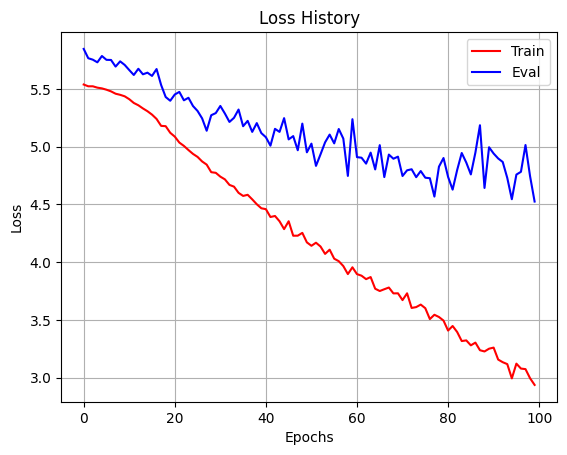

In [ ]:
loss_plot(train_loss, test_loss)

In [ ]:
model_predict('What is it coronavirus?', model)

'<bos> cdc is not aware of any scientific reports of the virus that causes <unk> . however , there is no evidence that the virus that causes <unk> is not to be spread from the virus that causes <unk> .'

In [ ]:
train_loss, test_loss = train(20, model, critereion, optimizer, train_loader, test_loader, len(vocabular), device)